# Определение процентного содержания продукта в смеси


Есть производство некоторого продукта посредством электролиза (нагреваемый ящик, стоит в неотапливаемом помещении).
Заглядывать в ящик часто нельзя - лабораторный сбор по уточнению процентного содержания в смеси происходит дважды
в день, хотелось бы делать замеры еще реже и в перспективе полагаться только на модель.


In [1]:
#импорт библиотек
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,mean_absolute_error
from statsmodels.tsa.seasonal import seasonal_decompose
from lightgbm import LGBMRegressor

## Данные о процентном содержании продукта

In [2]:
#посмотрим файл target
target_product_percents = pd.read_csv('target.csv', sep = ';',index_col=[0], parse_dates=[0])
target_product_percents=target_product_percents.astype(float) 
display(target_product_percents.head())

,product_percents
2018-07-28 05:00:00,3.68
2018-07-28 14:00:00,3.49
2018-07-29 05:00:00,3.61
2018-07-29 14:00:00,3.65
2018-07-30 05:00:00,3.41


In [3]:
target_product_percents.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 166 entries, 2018-07-28 05:00:00 to 2018-10-18 14:00:00
Data columns (total 1 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   product_percents  131 non-null    float64
dtypes: float64(1)
memory usage: 2.6 KB


In [4]:
#проверим пропущенные значения
target_product_percents.isnull().sum()

product_percents    35
dtype: int64

In [5]:
#заменим пропущенные значения
target_product_percents = target_product_percents.fillna(target_product_percents.mean())
target_product_percents.isnull().sum()

product_percents    0
dtype: int64

### Вывод 

В файле всего 166 строк и 2 столбца:
- столбец с датой, преобразованный в индекс
- столбец product_percents с процентным содержанием продукта

Проверка на дубликаты была проведена до преобразования даты в индекс, дубликатов не обнаружено.
Есть 35 пропущенных значений, они последние в списке.Я решила заменить их средним значением. Замена на предыдущее значение не подходит, потому что здесь абсолютно одинаковые значения 2 раза день невозможно. Поэтому взято среднее.

Также,имея только этот файл можно сделать предсказание используя временные ряды, т.к. мы преобразовали дату в индекс.
Ресемрлирование здесь не особо нужно, можно было бы посмотреть стандартное отклонение, но зато можно добавить факторов.
Тут подойдет час, lag и rolling (те же факторы, что и будут далее).
В итоге здесь результат rmse на RandomForestRegressor показал 0.06 на тесте. Но нам даны еще файлы, поэтому просто делать выводы по одному файлу неверно. Но выводы оставлю.

## Данные, полученные в результате электролиза


In [6]:
#посмотрим файл 3min Series (00sec) Outer new
about_production = pd.read_csv('3min Series (00sec) Outer new.csv',index_col=[0], parse_dates=[0])
display(about_production.head())

,Шум,Обратная ЭДС,Ср.прир.напр.,Сум.доз АПГ,Board Temp. 1,Board Temp. 2,Board Temp. 3,Board Temp. 4,Board Temp. 5,Board Temp. 6,Board Temp. 7,Board Temp. 8,Board Temp. 9,Board Temp. 10,Board Face Temp. 1,Board Face Temp. 6,Board Deaf Temp. 1,Board Deaf Temp. 6
Date,,,,,,,,,,,,,,,,,,
2018-07-30 22:46:00,0.016,2.277,-1.1,7.0,234.0,311.0,285.0,267.0,333.0,316.0,237.0,357.0,322.0,328.0,296.0,295.0,250.0,218.0
2018-07-30 22:49:00,0.014,2.277,-0.8,7.0,236.0,313.0,284.0,270.0,333.0,318.0,243.0,358.0,324.0,328.0,301.0,296.0,253.0,219.0
2018-07-30 22:52:00,0.016,2.277,-0.9,6.0,236.0,312.0,281.0,270.0,331.0,319.0,244.0,357.0,325.0,328.0,301.0,296.0,253.0,219.0
2018-07-30 22:55:00,0.014,2.277,-1.0,7.0,237.0,313.0,283.0,266.0,332.0,317.0,243.0,359.0,325.0,328.0,300.0,296.0,252.0,218.0
2018-07-30 22:58:00,0.017,2.277,-0.8,8.0,236.0,312.0,284.0,265.0,332.0,316.0,241.0,359.0,324.0,329.0,299.0,296.0,253.0,218.0


In [7]:
about_production.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 52269 entries, 2018-07-30 22:46:00 to 2018-07-29 08:01:00
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Шум                 51327 non-null  float64
 1   Обратная ЭДС        51327 non-null  float64
 2   Ср.прир.напр.       49631 non-null  float64
 3   Сум.доз АПГ         51328 non-null  float64
 4   Board Temp. 1       50850 non-null  float64
 5   Board Temp. 2       50850 non-null  float64
 6   Board Temp. 3       50850 non-null  float64
 7   Board Temp. 4       50850 non-null  float64
 8   Board Temp. 5       50850 non-null  float64
 9   Board Temp. 6       50850 non-null  float64
 10  Board Temp. 7       50850 non-null  float64
 11  Board Temp. 8       50850 non-null  float64
 12  Board Temp. 9       50850 non-null  float64
 13  Board Temp. 10      50850 non-null  float64
 14  Board Face Temp. 1  50850 non-null  float64
 15  Board Face Temp. 6

In [8]:
#переименуем колонки
about_production = about_production.rename(columns={'Шум': 'electrical_noise','Обратная ЭДС': 'back_emf',
                                          'Ср.прир.напр.': 'avg_volt_increase','Сум.доз АПГ': 'sum_dose_autosystem',
                                          'Board Temp. 1': 'board_temp_1','Board Temp. 2': 'board_temp_2',
                                          'Board Temp. 3': 'board_temp_3','Board Temp. 4': 'board_temp_4',
                                          'Board Temp. 5': 'board_temp_5','Board Temp. 6': 'board_temp_6',
                                          'Board Temp. 7': 'board_temp_7','Board Temp. 8': 'board_temp_8',
                                          'Board Temp. 9': 'board_temp_9','Board Temp. 10': 'board_temp_10',
                                          'Board Face Temp. 1': 'board_face_temp_1','Board Face Temp. 6': 'board_face_temp_6',
                                          'Board Deaf Temp. 1': 'board_deaf_temp_1','Board Deaf Temp. 6': 'board_deaf_temp_6'})

In [9]:
about_production.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 52269 entries, 2018-07-30 22:46:00 to 2018-07-29 08:01:00
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   electrical_noise     51327 non-null  float64
 1   back_emf             51327 non-null  float64
 2   avg_volt_increase    49631 non-null  float64
 3   sum_dose_autosystem  51328 non-null  float64
 4   board_temp_1         50850 non-null  float64
 5   board_temp_2         50850 non-null  float64
 6   board_temp_3         50850 non-null  float64
 7   board_temp_4         50850 non-null  float64
 8   board_temp_5         50850 non-null  float64
 9   board_temp_6         50850 non-null  float64
 10  board_temp_7         50850 non-null  float64
 11  board_temp_8         50850 non-null  float64
 12  board_temp_9         50850 non-null  float64
 13  board_temp_10        50850 non-null  float64
 14  board_face_temp_1    50850 non-null  float64
 15  b

In [10]:
#проверим пропущенные значения
about_production.isnull().sum()

electrical_noise        942
back_emf                942
avg_volt_increase      2638
sum_dose_autosystem     941
board_temp_1           1419
board_temp_2           1419
board_temp_3           1419
board_temp_4           1419
board_temp_5           1419
board_temp_6           1419
board_temp_7           1419
board_temp_8           1419
board_temp_9           1419
board_temp_10          1419
board_face_temp_1      1419
board_face_temp_6      1419
board_deaf_temp_1      1419
board_deaf_temp_6      1419
dtype: int64

In [11]:
#заменим пропущенные значения средними
about_production = about_production.fillna(about_production.mean())
about_production.isnull().sum()

electrical_noise       0
back_emf               0
avg_volt_increase      0
sum_dose_autosystem    0
board_temp_1           0
board_temp_2           0
board_temp_3           0
board_temp_4           0
board_temp_5           0
board_temp_6           0
board_temp_7           0
board_temp_8           0
board_temp_9           0
board_temp_10          0
board_face_temp_1      0
board_face_temp_6      0
board_deaf_temp_1      0
board_deaf_temp_6      0
dtype: int64

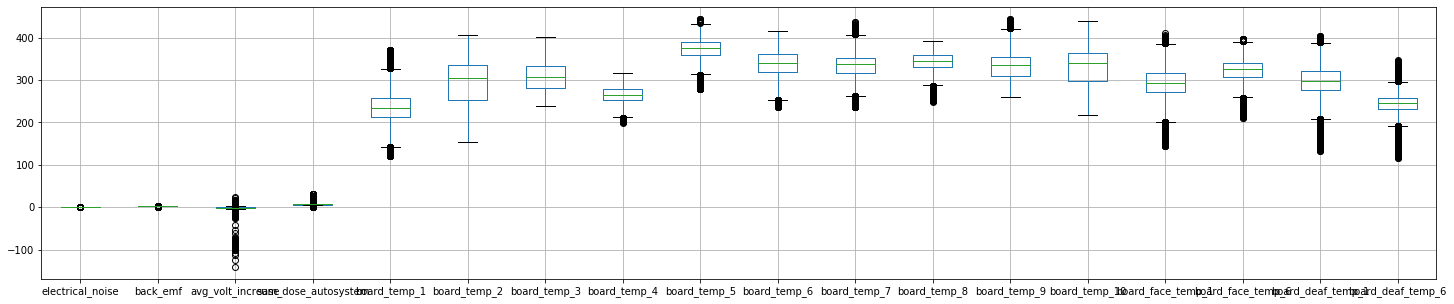

In [12]:
#посмотрим выбросы
about_production.boxplot(figsize=(25,5)) 

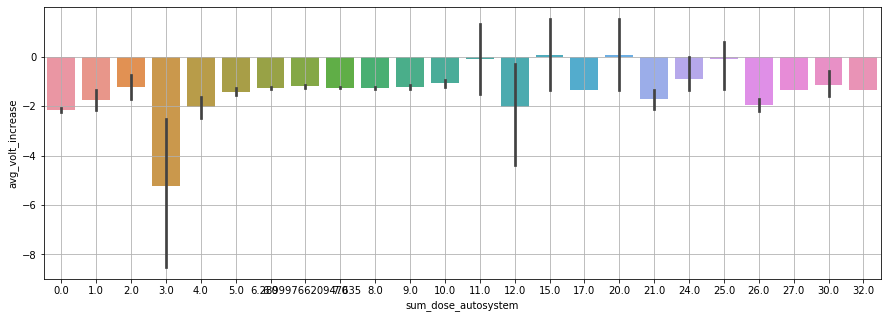

In [13]:
#посмотрим зависимость прироста напряжения от суммы доз
fig, ax = plt.subplots(figsize=(15, 5)) #размеры графика
sns.barplot(x = 'sum_dose_autosystem', y ='avg_volt_increase', data = about_production) #данные для графика
ax.grid() #показ решетки графика

### Вывод 

В файле 52269 строк и 18 колонок:
- `Шум` в электрике
- `Обратная ЭДС` сети устройства
- `Ср.прир.напр` Средний прирост напряжения в сети
- `Сум.доз АПГ` Сумма доз АПГ (происходит периодичный вброс катализатора в ящик - это число соответствует 
	количеству раз вбрасывания за промежуток времени)
- Температурные датчики (ящик прямоугольной формы, они располагаются по всему периметру
	- `Board Temp. {i}` - датчики температуры по длинне ящика с обоих сторон
	- `Board Face Temp. {1,6}` - датчики с лицевой стороны
	- `Board Deaf Temp. {1,6}` - датчики с тыльной стороны


Проверка на дубликаты была проведена до преобразования даты в индекс, дубликатов не обнаружено.
Есть много пропущенных значений, они все идут в разброс. Здесь решено заменить также средним значеним. Раз мы начали так делать с предыдущим файлом, то повторим здесь, чтобы не было путанницы. Кроме того, среднее дает нам необходимую примерную среднюю картину, которую мы потом будет уточнять.

При замене на предыдущие значения, разница в результате не велика, но, возможно, не точна. Заменить на предыдущие можно: пропущенные данные идут не подряд, это данные, которые получены посредством преобразования материалов.

Выбросы у нас есть, но по факту они не столь критично влияют на результат. Если хочется больше, то можно их убрать.

Также, логично, что чем выше средний прирост напряжения, тем больше сумма прироста доз. Исключение составляет прирост доз на 26, стоит рассмотреть подробнее эти данные. Также есть вопросы к 25 дозе и немного к 3. Всё это стоит посмотреть внимательно при дальнейшем исследовании.

### Данные о доли выбросов

In [14]:
#посмотрим файл Средняя масса доли АПГ New
mean_dose_autosystem_new = pd.read_csv('Средняя масса доли АПГ New.csv',index_col=[0], parse_dates=[0])
mean_dose_autosystem_new = mean_dose_autosystem_new.astype(float) 
display(mean_dose_autosystem_new.head())

,avg_mass_apg
Dateparse,
2018-07-30 23:00:00,0.50
2018-07-31 00:00:00,0.51
2018-07-31 01:00:00,0.51
2018-07-31 02:00:00,0.51
2018-07-31 03:00:00,0.51


In [15]:
mean_dose_autosystem_new.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2028 entries, 2018-07-30 23:00:00 to 2018-10-23 10:00:00
Data columns (total 1 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   avg_mass_apg  2028 non-null   float64
dtypes: float64(1)
memory usage: 31.7 KB


In [16]:
mean_dose_autosystem_new.isnull().sum()

avg_mass_apg    0
dtype: int64

### Вывод 

В файле 2028 строк и 2 столбца:
- столбец с датой, преобразованный в индекс
- `Сумма доз АПГ` - массовые доли каждого из вбросов


Проверка на дубликаты была проведена до преобразования даты в индекс, дубликатов не обнаружено.
Пропущенных значений нет.

# Подготовка данных к модели

In [17]:
#сделаем ресемплинг по 1 часу
about_production_hour = about_production.resample('1H').sum()
about_production_hour.sort_index(inplace=True)
about_production_hour.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2617 entries, 2018-07-27 22:00:00 to 2018-11-13 22:00:00
Freq: H
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   electrical_noise     2617 non-null   float64
 1   back_emf             2617 non-null   float64
 2   avg_volt_increase    2617 non-null   float64
 3   sum_dose_autosystem  2617 non-null   float64
 4   board_temp_1         2617 non-null   float64
 5   board_temp_2         2617 non-null   float64
 6   board_temp_3         2617 non-null   float64
 7   board_temp_4         2617 non-null   float64
 8   board_temp_5         2617 non-null   float64
 9   board_temp_6         2617 non-null   float64
 10  board_temp_7         2617 non-null   float64
 11  board_temp_8         2617 non-null   float64
 12  board_temp_9         2617 non-null   float64
 13  board_temp_10        2617 non-null   float64
 14  board_face_temp_1    2617 non-null   float64

***В одной таблице более 50000 значений, а в другой чуть больше 2000. Но по факту, нас интересуют замеры пару раз в день. Поэтому делаем ресемплинг по часу.***

In [18]:
#соединим таблицы с данными без Target
about_production_mean_dose = about_production_hour.join(mean_dose_autosystem_new)
about_production_mean_dose.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2617 entries, 2018-07-27 22:00:00 to 2018-11-13 22:00:00
Freq: H
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   electrical_noise     2617 non-null   float64
 1   back_emf             2617 non-null   float64
 2   avg_volt_increase    2617 non-null   float64
 3   sum_dose_autosystem  2617 non-null   float64
 4   board_temp_1         2617 non-null   float64
 5   board_temp_2         2617 non-null   float64
 6   board_temp_3         2617 non-null   float64
 7   board_temp_4         2617 non-null   float64
 8   board_temp_5         2617 non-null   float64
 9   board_temp_6         2617 non-null   float64
 10  board_temp_7         2617 non-null   float64
 11  board_temp_8         2617 non-null   float64
 12  board_temp_9         2617 non-null   float64
 13  board_temp_10        2617 non-null   float64
 14  board_face_temp_1    2617 non-null   float64

In [19]:
#проверим пропущенные значения и заменим их предыдущими
about_production_mean_dose = about_production_mean_dose.ffill().bfill()
about_production_mean_dose.isnull().sum()

electrical_noise       0
back_emf               0
avg_volt_increase      0
sum_dose_autosystem    0
board_temp_1           0
board_temp_2           0
board_temp_3           0
board_temp_4           0
board_temp_5           0
board_temp_6           0
board_temp_7           0
board_temp_8           0
board_temp_9           0
board_temp_10          0
board_face_temp_1      0
board_face_temp_6      0
board_deaf_temp_1      0
board_deaf_temp_6      0
avg_mass_apg           0
dtype: int64

***Здесь замена средним не подойдет, потому что эти данные уже среднее. Тут только замена предыдущими значениями***

In [20]:
#посчтаем сколько всего масс было вброшено
about_production_mean_dose['sum_mass_dose']= about_production_mean_dose['sum_dose_autosystem'] * about_production_mean_dose['avg_mass_apg']    
about_production_mean_dose.sort_index(inplace=True)
about_production_mean_dose.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2617 entries, 2018-07-27 22:00:00 to 2018-11-13 22:00:00
Freq: H
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   electrical_noise     2617 non-null   float64
 1   back_emf             2617 non-null   float64
 2   avg_volt_increase    2617 non-null   float64
 3   sum_dose_autosystem  2617 non-null   float64
 4   board_temp_1         2617 non-null   float64
 5   board_temp_2         2617 non-null   float64
 6   board_temp_3         2617 non-null   float64
 7   board_temp_4         2617 non-null   float64
 8   board_temp_5         2617 non-null   float64
 9   board_temp_6         2617 non-null   float64
 10  board_temp_7         2617 non-null   float64
 11  board_temp_8         2617 non-null   float64
 12  board_temp_9         2617 non-null   float64
 13  board_temp_10        2617 non-null   float64
 14  board_face_temp_1    2617 non-null   float64

***Создадим столбец, в котором можно узнать сколько в итоге масс было вброшено за период***

In [21]:
#соединим данные с target
about_production_mean_dose_target = about_production_mean_dose.join(target_product_percents)
#проверим пропущенные значения и заменим их предыдущими
about_production_mean_dose_target = about_production_mean_dose_target.ffill().bfill()
about_production_mean_dose_target.isnull().sum()
about_production_mean_dose_target.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2617 entries, 2018-07-27 22:00:00 to 2018-11-13 22:00:00
Freq: H
Data columns (total 21 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   electrical_noise     2617 non-null   float64
 1   back_emf             2617 non-null   float64
 2   avg_volt_increase    2617 non-null   float64
 3   sum_dose_autosystem  2617 non-null   float64
 4   board_temp_1         2617 non-null   float64
 5   board_temp_2         2617 non-null   float64
 6   board_temp_3         2617 non-null   float64
 7   board_temp_4         2617 non-null   float64
 8   board_temp_5         2617 non-null   float64
 9   board_temp_6         2617 non-null   float64
 10  board_temp_7         2617 non-null   float64
 11  board_temp_8         2617 non-null   float64
 12  board_temp_9         2617 non-null   float64
 13  board_temp_10        2617 non-null   float64
 14  board_face_temp_1    2617 non-null   float64

***Здесь тоже замена средним не подойдет, потому что эти данные уже среднее. Тут только замена предыдущими значениями***

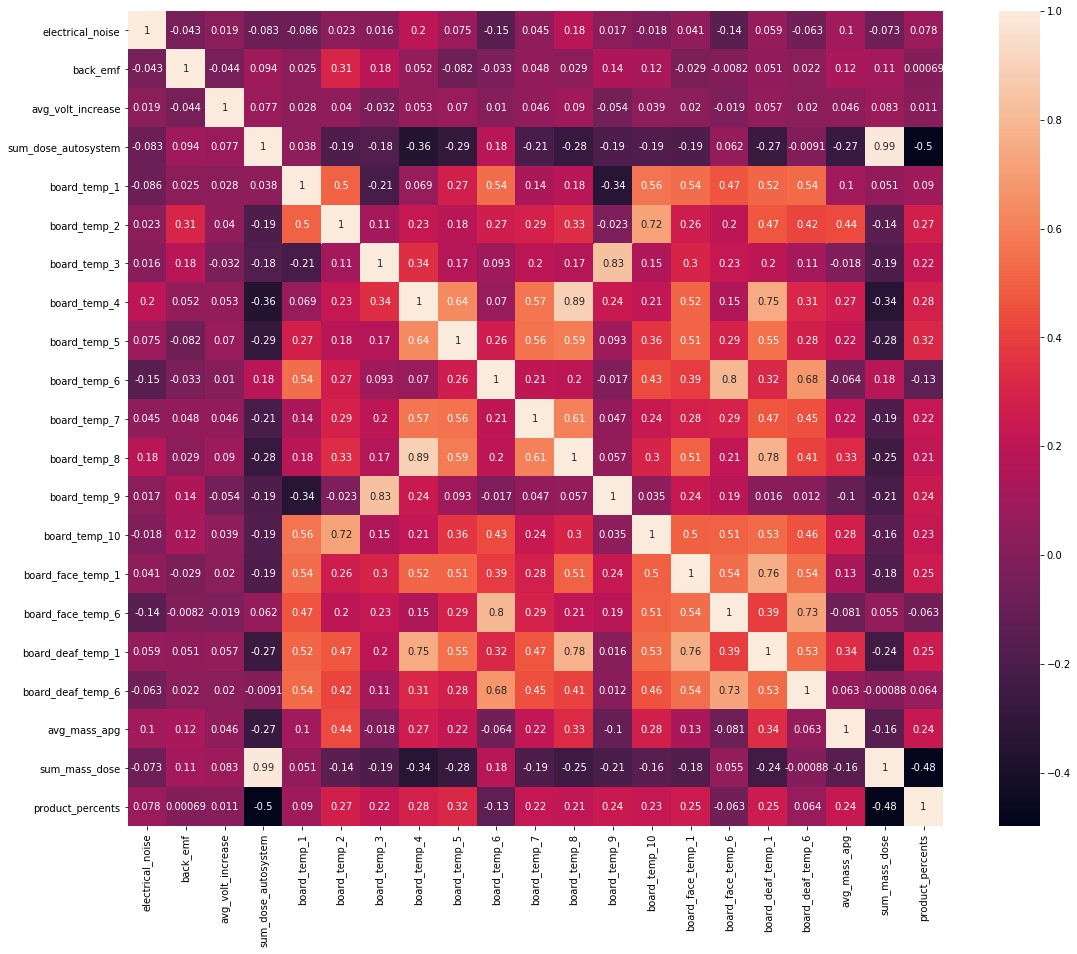

In [22]:
#построим и отрисуем матрицу корреляций
corr_matrix = about_production_mean_dose_target.corr()
plt.figure(figsize=(20, 15))
sns.heatmap(corr_matrix, annot = True, square=True)
plt.show()

***Матрица корреляций пригодится нам дальше. У нас много датчиков, как видно, некоторые из них сильно коррелируются, можно будет убрать некоторые столбцы***

In [23]:
#добавим столбцов 
def make_features(about_production_mean_dose_target, max_lag, rolling_mean_size):
    about_production_mean_dose_target['hour'] = about_production_mean_dose_target.index.hour
    
    for lag in range(1, max_lag + 55):
        about_production_mean_dose_target['lag_{}'.format(lag)] = about_production_mean_dose_target['product_percents'].shift(lag)

    about_production_mean_dose_target['rolling_mean'] = about_production_mean_dose_target['product_percents'].shift().rolling(rolling_mean_size).mean()

make_features(about_production_mean_dose_target, 1, 1)

In [24]:
***Так как мы используем дату в качестве индекса, такие столбцы помогут создать более точную картину***

SyntaxError: invalid syntax (<ipython-input-24-390f396a289d>, line 1)

### Вывод 

У нас получился итоговый файл, где содержатся все предыдущие данные.

Сначала была идея сделать ресемплинг по дню, но значений оказалось около 100, мне показалось, что это мало. Сейчас у нас ресемплинг по часу, значений чуть больше 2500.

Замена пропущенных значений произведена на предыдущее, чтобы не плодить среднее среднего и получить более адекватные результаты.

Создан столбец, в котором можно увидеть сколько в итоге масс было вброшено за период. Столбцы с данными, которые мы перемножали удалим.

По матрице корреляий у нас выходит,что есть значения, которые сильно коррелируются. 

Я решила удалить:
- 'sum_dose_autosystem' и 'avg_mass_apg' у нас уже есть произведение этих данных
- датчики 2,4,9, а также датчик с лицевой стороны 6 и с тыльной 1, как наиболее коррелируемые и часто встречаемые

# Модель

In [ ]:
#выделяем цель
features = about_production_mean_dose_target.drop(['product_percents','sum_dose_autosystem','avg_mass_apg',
                                                   'board_deaf_temp_1','board_temp_8','board_temp_9',
                                                   'board_face_temp_6'], axis=1)
target = about_production_mean_dose_target['product_percents']

#поделим сначала на 2 выборки
features_train_valid, features_test, target_train_valid, target_test = train_test_split(
    features, target, test_size=0.20, random_state=12345)

#тут добавим третью 
features_train, features_valid, target_train, target_valid = train_test_split(
    features_train_valid, target_train_valid, test_size=0.250, random_state=12345)

print(features_train.shape)
print(features_valid.shape)
print(features_test.shape)

In [ ]:
#гиперпараметры для LightGBM num_leaves
for nl in range(5, 21):
    model =  LGBMRegressor(random_state=12345,num_leaves=nl)
    model.fit(features_train,target_train)
    predictions_valid = model.predict(features_valid)
    rmse = (mean_squared_error(target_valid,predictions_valid))**0.5
    print("num_leaves =", nl, ": ", end='') 
    print('RMSE:', rmse)

In [ ]:
#гиперпараметры для LightGBM num_leaves
for ms in range(5, 11):
    model =  LGBMRegressor(random_state=12345,num_leaves = 17,min_child_samples=ms)
    model.fit(features_train,target_train)
    predictions_valid = model.predict(features_valid)
    rmse = (mean_squared_error(target_valid,predictions_valid))**0.5
    print("min_child_samples =", ms, ": ", end='') 
    print('RMSE:', rmse)

In [ ]:
#гиперпараметры для LightGBM max_depth
for depth in range(5, 11):
    model =  LGBMRegressor(random_state=12345, num_leaves=17,min_child_samples=7,max_depth=depth)
    model.fit(features_train,target_train)
    predictions_valid = model.predict(features_valid)
    rmse = (mean_squared_error(target_valid,predictions_valid))**0.5
    print("max_depth =", depth, ": ", end='') 
    print('RMSE:', rmse)

In [ ]:
#посмотрим на LGBMRegressor
model = LGBMRegressor(random_state=12345,num_leaves=17,min_child_samples=7,max_depth=8)
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)
rmse = (mean_squared_error(target_valid,predicted_valid))**0.5
print("rmse:", rmse)

In [ ]:
#посмотрим на test
model = LGBMRegressor(random_state=12345,num_leaves=17,min_child_samples=7,max_depth=8)
model.fit(features_train, target_train)
predicted_test = model.predict(features_test)
rmse = (mean_squared_error(target_test,predicted_test))**0.5
print("rmse:", rmse)

# Вывод

Было решено взять LGBMRegressor как наиболее подходящее по количеству, типу данных,а также по соответсвию запроса.Бустинг в таких даннных самое адекватное средство. Это не чистый случайный лес, хотя принцип такой же, поэтому он дает результаты выше.

Итак, произведя манипуляции с ресемплированием данных по часу, удалением коррелирующихся столбцов, а также заменой на предыдущие и средние значений, мы получили среднеквадратичную ошибку модели равную 0,1.

Это хорошее значение, оно не сильно отличается от реальных показателей. Возможно, стоит обработать данные за больший период, тогда можно будет улучшить модель.